In [3]:
import requests, re, html, csv
from bs4 import BeautifulSoup


In [4]:
# Function to search for a movie by title
def search_movie_by_title(title):
    search_url = f'http://www.boxofficemojo.com/search/?q={title.replace(" ", "+")}'
    response = requests.get(search_url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the first search result link
        result_link = soup.find('a', {'class': 'a-size-medium a-link-normal a-text-bold'})
        print("results: ", result_link)
        if result_link:
            movie_url = result_link['href']
            return movie_url
        else:
            return None
    else:
        print(f'Failed to retrieve search results. Status Code: {response.status_code}')
        return None

def extract_values_from_html_array(html_array):
    pattern = r'<span class="money">\$([0-9,]+)</span>'
    values = []

    for item in html_array:
        match = re.search(pattern, str(item))
        if match:
            value = match.group(1)
            value = int(value.replace(',', ''))
            values.append(value)
    return values


# Function to scrape box office revenue and budget from a movie's page
def scrape_movie_data(movie_url):
    print("movie url::", 'https://www.boxofficemojo.com' + movie_url)
    response = requests.get('https://www.boxofficemojo.com' + movie_url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        revenue_element = soup.find('div', {'class': 'a-section a-spacing-none mojo-performance-summary-table'})
        budget_element = soup.find('div', {'class': 'a-section a-spacing-none mojo-summary-values mojo-hidden-from-mobile'})


        if revenue_element and budget_element:
            revenue = revenue_element.find_all('span', {'class': 'money'})
            budget = budget_element.find_all('span', {'class': 'money'})

            return revenue, budget
        else:
            return None, None
    else:
        print(f'Failed to retrieve data. Status Code: {response.status_code}')
        return None, None


def revenue_budget(title):
  print("Title: ", title)
  movie_url = search_movie_by_title(title)
  print(movie_url)
  if movie_url:
      revenue, budget = scrape_movie_data( movie_url)

      if revenue:
          data = extract_values_from_html_array(revenue)
          if len(data) == 2:
            domestic, international, worldwide = data[0], 0, data[1]
          else:
            domestic, international, worldwide = data

          if budget:
            budget = extract_values_from_html_array(budget)
            budget = 0 if len(budget) == 1 else budget[-1]
            print("Data: ", data)
          else:
            budget = 0

          return domestic, international, worldwide, budget
      else:
          print('Data not found.')
          return 0,0,0,0
  else:
      print('Movie not found in Box Office Mojo.')
      return 0,0,0,0




In [27]:
import csv
import os
from tqdm import tqdm

def append_movie_data_to_csv(input_file, output_file, checkpoint_file):
    with open(input_file, 'r') as csv_input, open(output_file, 'w', newline='') as csv_output:
        reader = csv.reader(csv_input)
        writer = csv.writer(csv_output)
        
        header = next(reader)
        header.extend(["domestic_revenue", "international_revenue", "worldwide_revenue", "budget"])
        writer.writerow(header)
        
        # Load the last checkpoint
        last_row_index = load_checkpoint(checkpoint_file)

        for i, row in enumerate(tqdm(reader, desc="Processing rows"), start=1):
            if i <= last_row_index:
                continue  # Skip rows until the checkpoint is reached
            
            movie_name = row[1]  # Assuming movie name is in the second column
            domestic_revenue, international_revenue, worldwide_revenue, budget = revenue_budget(movie_name)
            print("csv data: ", domestic_revenue, international_revenue, worldwide_revenue, budget)
            row.extend([domestic_revenue, international_revenue, worldwide_revenue, budget])
            writer.writerow(row)
            writer.flush()
            os.fsync(csv_output.fileno())  # Sync the file to disk
            
            # Save the checkpoint
            save_checkpoint(checkpoint_file, i)

def save_checkpoint(checkpoint_file, index):
    with open(checkpoint_file, 'w') as file:
        file.write(str(index))

def load_checkpoint(checkpoint_file):
    try:
        with open(checkpoint_file, 'r') as file:
            return int(file.read().strip())
    except FileNotFoundError:
        return 0  # If the checkpoint file does not exist, start from the beginning

# Example usage
input_file = 'Data/Final/output_movies_data_0-35k_by_year_2000+.csv'
output_file = 'Data/Final/output_movies_data_hassan.csv'
checkpoint_file = 'Data/Final/checkpoint.txt'

# Call the function
append_movie_data_to_csv(input_file, output_file, checkpoint_file)


Processing rows: 0it [00:00, ?it/s]

Title:  0
results:  <a class="a-size-medium a-link-normal a-text-bold" href="/title/tt10545296/?ref_=bo_se_r_1">The Hunger Games: The Ballad of Songbirds &amp; Snakes</a>
/title/tt10545296/?ref_=bo_se_r_1
movie url:: https://www.boxofficemojo.com/title/tt10545296/?ref_=bo_se_r_1


Processing rows: 0it [00:04, ?it/s]

Data not found.
csv data:  0 0 0 0


AttributeError: '_csv.writer' object has no attribute 'flush'

In [12]:
import csv

def calculate_percentage_of_zeros(input_file):
    with open(input_file, 'r') as csv_file:
        reader = csv.DictReader(csv_file)

        # Initialize counters for each column
        counts = {
            "domestic_revenue": {"zero": 0, "non_zero": 0},
            "international_revenue": {"zero": 0, "non_zero": 0},
            "worldwide_revenue": {"zero": 0, "non_zero": 0},
            "budget": {"zero": 0, "non_zero": 0}
        }

        # Count zero and non-zero values for each column
        for row in reader:
            for column in counts:
                value = int(row[column]) if row[column].isdigit() else 0
                if value == 0:
                    counts[column]["zero"] += 1
                else:
                    counts[column]["non_zero"] += 1

        # Calculate percentages
        percentages = {}
        for column, count in counts.items():
            total = count["zero"] + count["non_zero"]
            percentages[column] = {
                "zero_percentage": (count["zero"] / total) * 100,
                "non_zero_percentage": (count["non_zero"] / total) * 100
            }

        return percentages

# Example usage
output_file = 'Data/Final/output_movies_data_25k_hassan.csv'
percentages = calculate_percentage_of_zeros(output_file)
for column, percentage in percentages.items():
    print(f"{column}: Zero - {percentage['zero_percentage']:.2f}%, Non-Zero - {percentage['non_zero_percentage']:.2f}%")



domestic_revenue: Zero - 8.24%, Non-Zero - 91.76%
international_revenue: Zero - 52.94%, Non-Zero - 47.06%
worldwide_revenue: Zero - 8.24%, Non-Zero - 91.76%
budget: Zero - 75.29%, Non-Zero - 24.71%


In [16]:
import csv

def remove_columns_and_zero_rows(input_file, output_file, columns_to_remove, check_zero_columns):
    with open(input_file, 'r') as csv_input, open(output_file, 'w', newline='') as csv_output:
        reader = csv.DictReader(csv_input)
        fieldnames = [field for field in reader.fieldnames if field not in columns_to_remove]

        writer = csv.DictWriter(csv_output, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            # Check if either of the remaining columns has a zero value
            if any(int(row[column]) == 0 for column in check_zero_columns if row[column].isdigit()):
                continue

            # Remove the unwanted columns
            for column in columns_to_remove:
                row.pop(column, None)
            writer.writerow(row)

# Example usage
input_file = 'Data/Final/output_movies_data_0-45k_by_year_2000+.csv'
output_file = 'Data/Final/Cleaned_output_movies_data_all_hassan.csv'
columns_to_remove = ["domestic_revenue", "international_revenue"]
check_zero_columns = ["worldwide_revenue", "budget"]  # Check these columns for zero values

remove_columns_and_zero_rows(input_file, output_file, columns_to_remove, check_zero_columns)


In [22]:


import csv
import math
import pandas as pd

def calculate_diversity_score(ethnicities):
    return -sum(p * math.log(p) for p in ethnicities if p > 0)

def load_cast_ethnicity(file_name):
    ethnicity_data = {}
    with open(file_name, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            name = row['Name']
            ethnicities = [float(row[ethnicity]) for ethnicity in row if ethnicity != 'Name' and ethnicity != '2PRACE']
            ethnicity_data[name] = calculate_diversity_score(ethnicities)
    return ethnicity_data

def get_average_diversity_score(actor_names, ethnicity_data, missing_actors):
    scores = []
    for name in actor_names:
        name = name.strip()
        print(f"Processing actor: {name}")  # Print each actor's name
        if name in ethnicity_data:
            scores.append(ethnicity_data[name])
        else:
            missing_actors.add(name)  # Add missing actor to the set
    return sum(scores) / len(scores) if scores else 0

def append_diversity_score_to_movies(movies_file, ethnicity_data, output_file):
    df = pd.read_csv(movies_file)
    missing_actors = set()  # Set to track actors not found in ethnicity data

    df['diversity_score'] = df['actors'].apply(lambda actors: 
        get_average_diversity_score([actor.strip() for actor in actors.split(',')], ethnicity_data, missing_actors) 
        if pd.notna(actors) else 0
    )

    df.to_csv(output_file, index=False)
    return missing_actors

# Load cast ethnicity data
cast_ethnicity_data = load_cast_ethnicity('Data/Final/Ethnicity/cast_ethnicity.csv')

# Append diversity score to each movie and get missing actors
missing_actors = append_diversity_score_to_movies('Data/Final/Cleaned_output_movies_data_25k_hassan.csv', cast_ethnicity_data, 'data_with_diversity.csv')
print(f"Actors not found in ethnicity data: {missing_actors}")

# Load the data with diversity scores
df = pd.read_csv('data_with_diversity.csv')

# Calculate profitability (assuming revenue and budget columns exist and are filled correctly)
df['profitability'] = df['worldwide_revenue'] - df['budget']

# Analyze correlation between diversity score and profitability
correlation = df['diversity_score'].corr(df['profitability'])
print("Correlation between diversity score and profitability:", correlation)



Processing actor: ['Ben Knight'
Processing actor: 'Yvon Chouinard'
Processing actor: 'Katie Lee'
Processing actor: 'Bruce Babbitt'
Processing actor: 'Mikal Jakubal']
Processing actor: ['Kathleen Turner'
Processing actor: 'Kevin Zegers'
Processing actor: 'Jessica Paré'
Processing actor: 'Frances Fisher'
Processing actor: 'Jacob Tierney']
Processing actor: ['Tom Everett Scott'
Processing actor: 'Mark-Paul Gosselaar'
Processing actor: 'Poppy Montgomery'
Processing actor: 'Lochlyn Munro'
Processing actor: 'Randy Pearlstein']
Processing actor: ['John Major Davis'
Processing actor: 'Lelia Symington'
Processing actor: 'Matt Leddo'
Processing actor: 'Mike H. Taylor'
Processing actor: 'Dan Severn']
Processing actor: ['Kate Bosworth'
Processing actor: 'Wes Bentley'
Processing actor: 'Olivia Rose Keegan'
Processing actor: 'Shashawnee Hall'
Processing actor: 'Richard Riehle']
Processing actor: ['Martin Anderson'
Processing actor: 'James Benson'
Processing actor: 'Wyatt Cenac'
Processing actor: 'Sa

/Users/hassan/miniconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/hassan/miniconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [23]:
import csv
import math
import pandas as pd
import ast  # Import ast module

def calculate_diversity_score(ethnicities):
    return -sum(p * math.log(p) for p in ethnicities if p > 0)

def load_cast_ethnicity(file_name):
    ethnicity_data = {}
    with open(file_name, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            name = row['Name']
            ethnicities = [float(row[ethnicity]) for ethnicity in row if ethnicity != 'Name' and ethnicity != '2PRACE']
            ethnicity_data[name] = calculate_diversity_score(ethnicities)
    return ethnicity_data

def get_average_diversity_score(actor_names, ethnicity_data, missing_actors):
    scores = []
    for name in actor_names:
        name = name.strip()
        print(f"Processing actor: {name}")  # Print each actor's name
        if name in ethnicity_data:
            scores.append(ethnicity_data[name])
        else:
            missing_actors.add(name)  # Add missing actor to the set
    return sum(scores) / len(scores) if scores else 0

def parse_actors(actor_string):
    try:
        return ast.literal_eval(actor_string)
    except:
        return []

def append_diversity_score_to_movies(movies_file, ethnicity_data, output_file):
    df = pd.read_csv(movies_file)
    missing_actors = set()  # Set to track actors not found in ethnicity data

    df['diversity_score'] = df['actors'].apply(lambda actors: 
        get_average_diversity_score(parse_actors(actors), ethnicity_data, missing_actors) 
        if pd.notna(actors) else 0
    )

    df.to_csv(output_file, index=False)
    return missing_actors

# Load cast ethnicity data
cast_ethnicity_data = load_cast_ethnicity('Data/Final/Ethnicity/cast_ethnicity.csv')

# Append diversity score to each movie and get missing actors
missing_actors = append_diversity_score_to_movies('Data/Final/Cleaned_output_movies_data_25k_hassan.csv', cast_ethnicity_data, 'data_with_diversity.csv')
print(f"Actors not found in ethnicity data: {missing_actors}")

# Load the data with diversity scores
df = pd.read_csv('data_with_diversity.csv')

# Calculate profitability (assuming revenue and budget columns exist and are filled correctly)
df['profitability'] = df['worldwide_revenue'] - df['budget']

# Analyze correlation between diversity score and profitability
correlation = df['diversity_score'].corr(df['profitability'])
print("Correlation between diversity score and profitability:", correlation)


Processing actor: Ben Knight
Processing actor: Yvon Chouinard
Processing actor: Katie Lee
Processing actor: Bruce Babbitt
Processing actor: Mikal Jakubal
Processing actor: Kathleen Turner
Processing actor: Kevin Zegers
Processing actor: Jessica Paré
Processing actor: Frances Fisher
Processing actor: Jacob Tierney
Processing actor: Tom Everett Scott
Processing actor: Mark-Paul Gosselaar
Processing actor: Poppy Montgomery
Processing actor: Lochlyn Munro
Processing actor: Randy Pearlstein
Processing actor: John Major Davis
Processing actor: Lelia Symington
Processing actor: Matt Leddo
Processing actor: Mike H. Taylor
Processing actor: Dan Severn
Processing actor: Kate Bosworth
Processing actor: Wes Bentley
Processing actor: Olivia Rose Keegan
Processing actor: Shashawnee Hall
Processing actor: Richard Riehle
Processing actor: Martin Anderson
Processing actor: James Benson
Processing actor: Wyatt Cenac
Processing actor: Sasha Dominy
Processing actor: Amr El-Bayoumi
Processing actor: Jessic

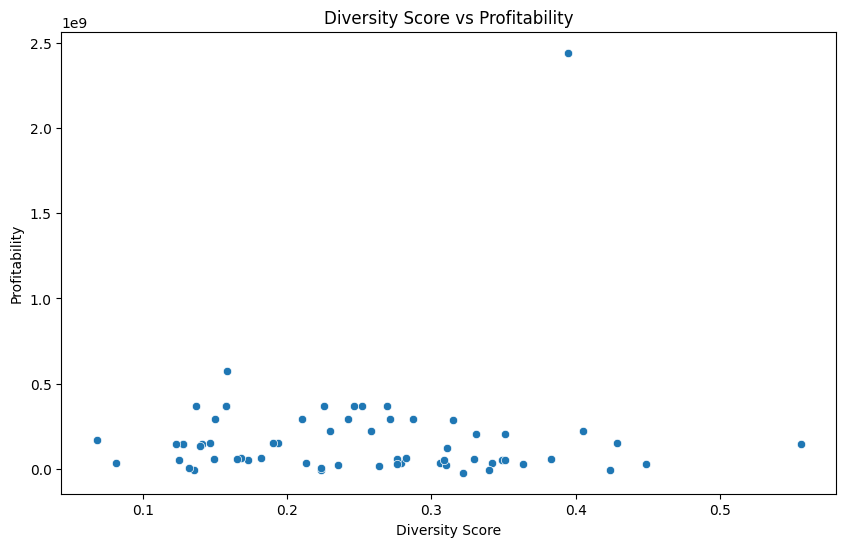

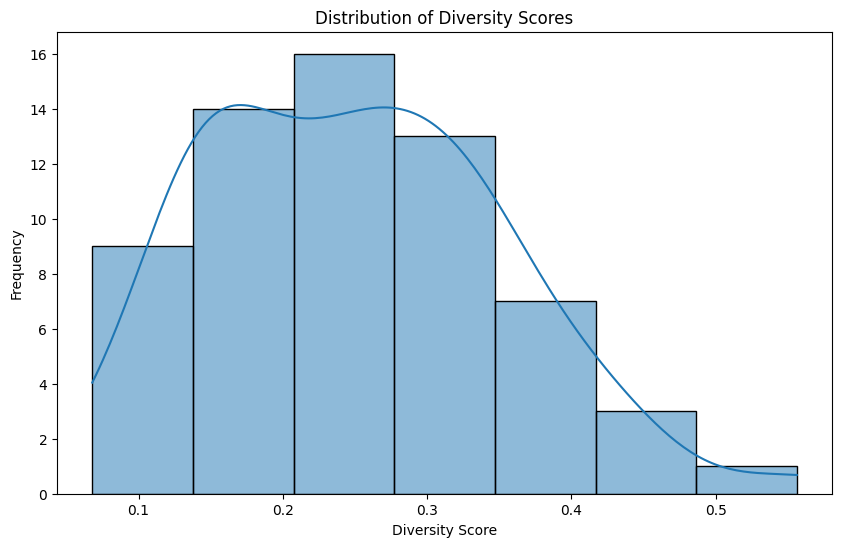

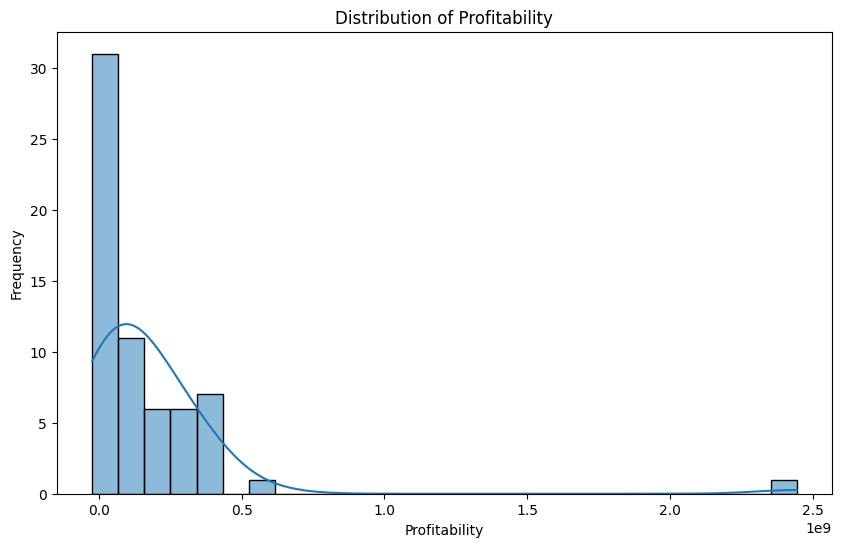

Correlation Coefficient: 0.09182189721854697
P-value: 0.47415599296560756
T-Statistic: 0.30908629277929384
P-value (T-test): 0.7590142295047331


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Load the data
df = pd.read_csv('data_with_diversity.csv')

# Calculate profitability
df['profitability'] = df['worldwide_revenue'] - df['budget']

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='diversity_score', y='profitability')
plt.title('Diversity Score vs Profitability')
plt.xlabel('Diversity Score')
plt.ylabel('Profitability')
plt.show()

# Histogram - Diversity Score
plt.figure(figsize=(10, 6))
sns.histplot(df['diversity_score'], kde=True)
plt.title('Distribution of Diversity Scores')
plt.xlabel('Diversity Score')
plt.ylabel('Frequency')
plt.show()

# Histogram - Profitability
plt.figure(figsize=(10, 6))
sns.histplot(df['profitability'], kde=True)
plt.title('Distribution of Profitability')
plt.xlabel('Profitability')
plt.ylabel('Frequency')
plt.show()

# Correlation
correlation, p_value = stats.pearsonr(df['diversity_score'], df['profitability'])
print(f"Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

# T-test (splitting data into high and low diversity)
median_diversity = df['diversity_score'].median()
high_diversity = df[df['diversity_score'] > median_diversity]['profitability']
low_diversity = df[df['diversity_score'] <= median_diversity]['profitability']

t_stat, p_val_t_test = stats.ttest_ind(high_diversity, low_diversity, equal_var=False)
print(f"T-Statistic: {t_stat}")
print(f"P-value (T-test): {p_val_t_test}")


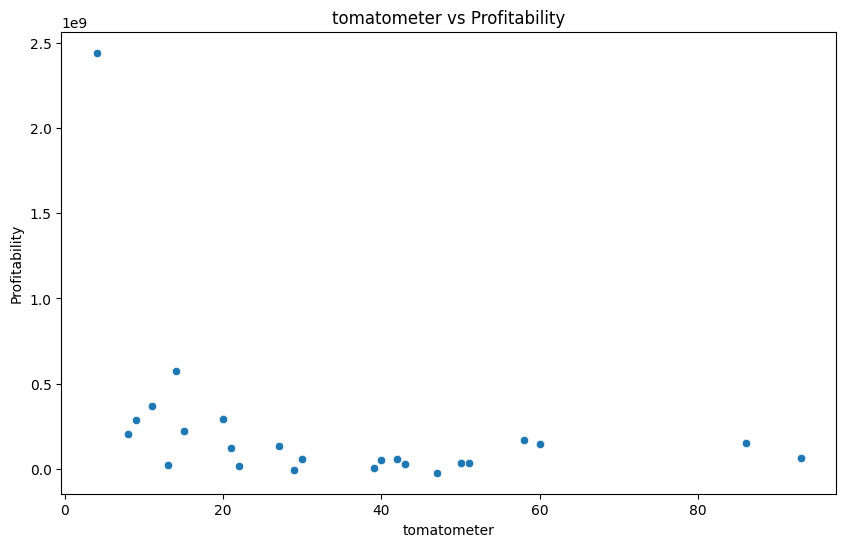

Correlation between tomatometer and profitability: -0.3346155050863225
P-value: 0.0073514535192146235
T-Statistic (High vs Low tomatometer): -2.6774479703495406
P-value (T-test): 0.011584552790168639


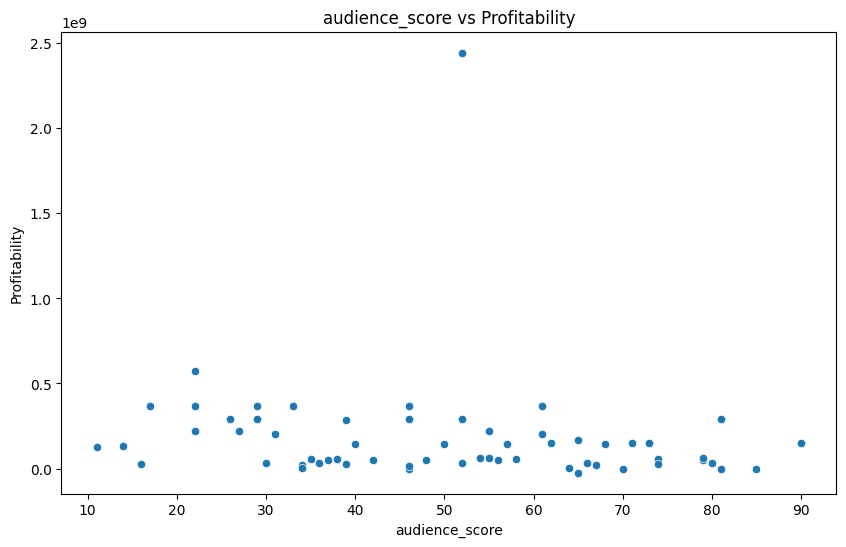

Correlation between audience_score and profitability: -0.12195931943753281
P-value: 0.3409964629552365
T-Statistic (High vs Low audience_score): -1.7190675790409617
P-value (T-test): 0.09375900288183056


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data
df = pd.read_csv('data_with_diversity.csv')

# Calculate profitability
df['profitability'] = df['worldwide_revenue'] - df['budget']

# Function to perform analysis
def analyze_correlation(column_name):
    # Scatter Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=column_name, y='profitability')
    plt.title(f'{column_name} vs Profitability')
    plt.xlabel(column_name)
    plt.ylabel('Profitability')
    plt.show()

    # Correlation
    correlation, p_value = stats.pearsonr(df[column_name], df['profitability'])
    print(f"Correlation between {column_name} and profitability: {correlation}")
    print(f"P-value: {p_value}")

    # T-test
    median_score = df[column_name].median()
    high_score = df[df[column_name] > median_score]['profitability']
    low_score = df[df[column_name] <= median_score]['profitability']

    t_stat, p_val_t_test = stats.ttest_ind(high_score, low_score, equal_var=False)
    print(f"T-Statistic (High vs Low {column_name}): {t_stat}")
    print(f"P-value (T-test): {p_val_t_test}")

# Analyze tomatometer vs profitability
analyze_correlation('tomatometer')

# Analyze audience score vs profitability
analyze_correlation('audience_score')


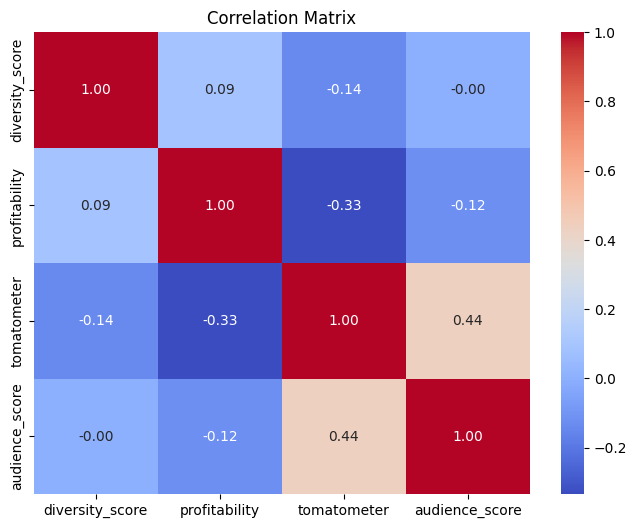

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('data_with_diversity.csv')

# Calculate profitability if it's not already a column
if 'profitability' not in df.columns:
    df['profitability'] = df['worldwide_revenue'] - df['budget']

# Select the columns of interest
data = df[['diversity_score', 'profitability', 'tomatometer', 'audience_score']]

# Compute the correlation matrix
corr_matrix = data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
